In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")

In [2]:
class SMAEMABacktester(): 
    
    def __init__(self, symbol, SMA, EMA, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMAEMABacktester(symbol = {}, SMA = {}, EMA = {}, start = {}, end = {})".format(self.symbol, self.SMA, self.EMA, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Daily_nifty_data.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean() 
        raw["EMA"] = raw["price"].ewm(span = self.EMA, min_periods = self.EMA).mean() 
        self.data = raw
        
    def set_parameters(self, SMA = None, EMA = None):
        ''' Updates SMA/EMA parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean() 
        if EMA is not None:
            self.EMA = EMA
            self.data["EMA"] = self.data["price"].ewm(span = self.EMA, min_periods = self.EMA).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA"] > data["SMA"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        # absolute performance of the strategy
        perf = data["cstrategy"].iloc[-1] 
        # out-/underperformance of strategy
        outperf = perf - data["creturns"].iloc[-1] 
        return round(perf, 6), round(outperf, 6)
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | EMA = {} | TC = {}".format(self.symbol, self.SMA, self.EMA, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMAEMA):
        ''' Updates SMA/EMA parameters and returns the negative absolute performance (for minimization algorithm).
        '''
        self.set_parameters(int(SMAEMA[0]), int(SMAEMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, EMA_range):
        ''' Finds global maximum given the SMA/EMA parameter ranges.
        '''
        opt = brute(self.update_and_run, (SMA_range, EMA_range), finish=None)
        return opt, -self.update_and_run(opt)
    
    

In [3]:
tester = SMAEMABacktester("Nifty50", 50, 50, "2008-01-01", "2022-07-01", 0.0004)

In [4]:
tester.test_strategy()

(0.88643, -2.356598)

In [5]:
tester.results

,price,returns,SMA,EMA,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2008-03-12,4872.000000,0.001253,5390.663984,5205.573344,-1,-0.001253,0.0,1.001254,0.998748
2008-03-13,4623.600098,-0.052331,5359.547988,5179.493623,-1,0.052331,0.0,0.950205,1.052405
2008-03-14,4745.799805,0.026086,5330.892988,5160.166854,-1,-0.026086,0.0,0.975318,1.025307
2008-03-17,4503.100098,-0.052494,5295.468994,5131.041628,-1,0.052494,0.0,0.925440,1.080567
2008-03-18,4533.000000,0.006618,5260.546992,5104.667540,-1,-0.006618,0.0,0.931585,1.073439
...,...,...,...,...,...,...,...,...,...
2022-06-24,15699.250000,0.009125,16356.184102,16269.356565,-1,-0.009125,0.0,3.226382,0.891003
2022-06-27,15832.049805,0.008423,16323.312090,16252.207281,-1,-0.008423,0.0,3.253674,0.883530
2022-06-28,15850.200195,0.001146,16296.843086,16236.442297,-1,-0.001146,0.0,3.257404,0.882518


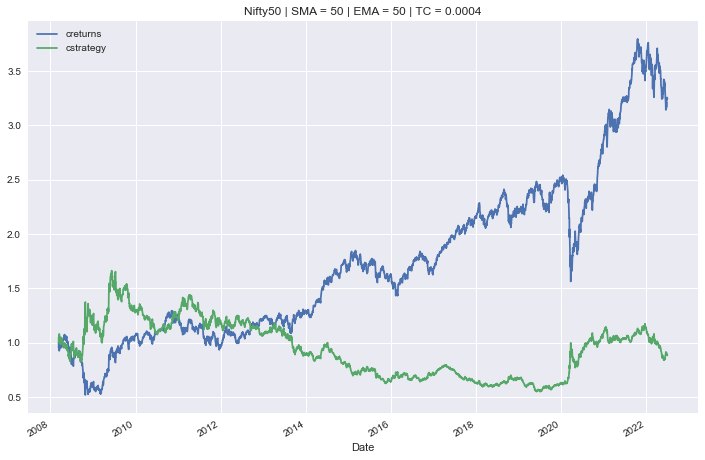

In [6]:
tester.plot_results()

In [7]:
tester.optimize_parameters((10, 100, 1), (10, 100, 1))

(array([31., 41.]), 6.059019)

In [8]:
tester.test_strategy()

(6.059019, 3.064692)

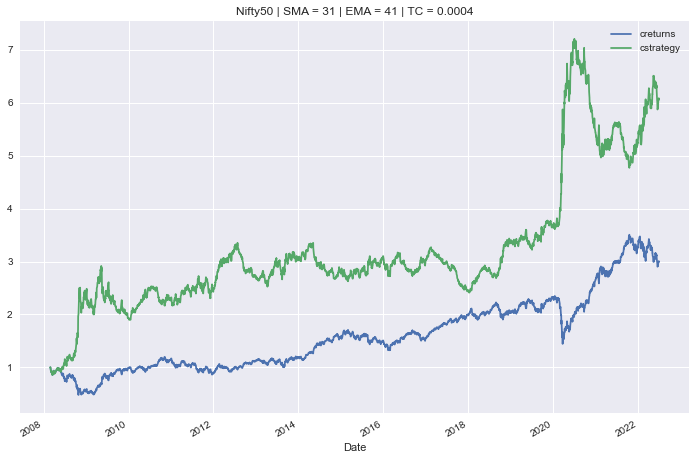

In [9]:
tester.plot_results()